## Load libraries and Data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import sys
sys.path.append("../src")
from extract_features import *
from visualize_audio import *
from prepare_data import *


constants

In [14]:
SAMPLING_RATING = 22050
FRAME_LENGTH_ENERGY = 2048  # 512
THRESHOLD_PERCENTAGE = 0.01  # percentage of max energy
MIN_SILENCE_DURATION = 1  # in seconds

# n_fft=512 # the window size
HOP_LENGTH = 512  # the number of samples between successive frames
SEGMENT_DURATION = 0.025  # in seceonds
SEGMENT_OVERLAP = 0.01  # in seceonds
N_MFCC = 13

## Preprocessing

### experimenting on some recording

In [15]:
audio1, SAMPLING_RATING = librosa.load("../data/raw/recordings/korean1.mp3", sr=SAMPLING_RATING)
audio2, SAMPLING_RATING = librosa.load("../data/raw/recordings/korean2.mp3", sr=SAMPLING_RATING)
audio3, SAMPLING_RATING = librosa.load("../data/raw/recordings/korean3.mp3", sr=SAMPLING_RATING)

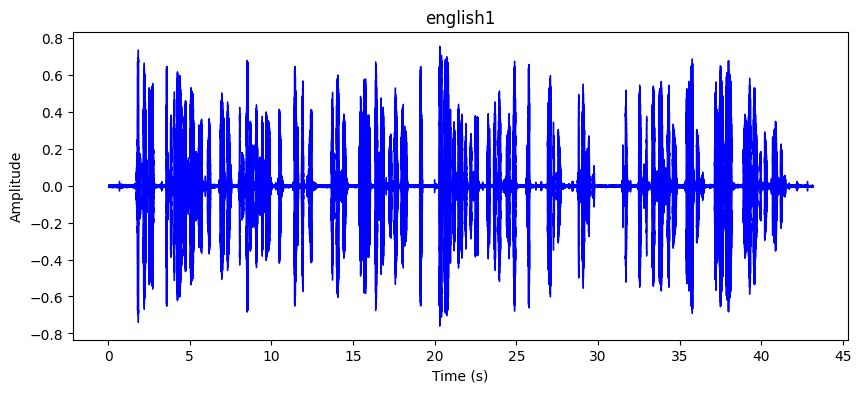

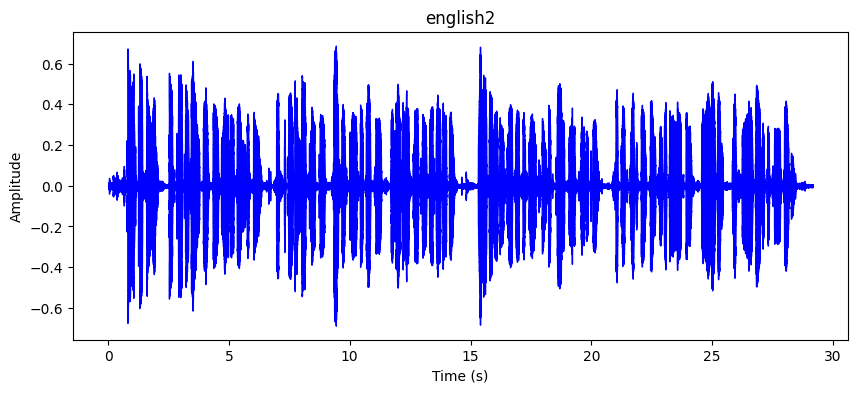

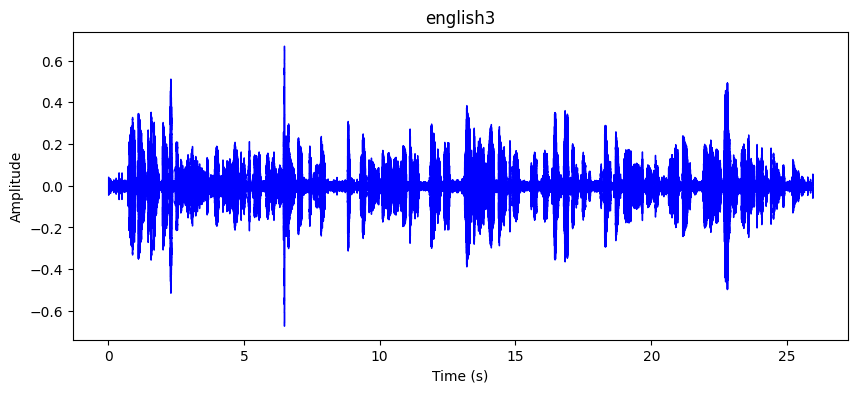

In [16]:
plot_audio(audio1, SAMPLING_RATING, title="english1")
plot_audio(audio2, SAMPLING_RATING, title="english2")
plot_audio(audio3, SAMPLING_RATING, title="english3")

In [17]:
energy = librosa.feature.rms(y=audio1)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for english 1:", round(100 * ratio, 2), "%")

energy = librosa.feature.rms(y=audio2)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for english 2:", round(100 * ratio, 2), "%")

energy = librosa.feature.rms(y=audio3)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for english 3:", round(100 * ratio, 2), "%")

ratio of silent segments for english 1: 34.32 %
ratio of silent segments for english 2: 1.75 %
ratio of silent segments for english 3: 0.0 %


This indicates that silence segments sometimes takes a big portion of the audio and thus the need to trim it.

It is worth noting that we aren't trying to makr the ratio as close to 0% as possible as small "silence" frames/segments are part of the accent.

That's why we choose to only remove the silence segment when it is lasts more than 1 second.

Number of audible segments: 1


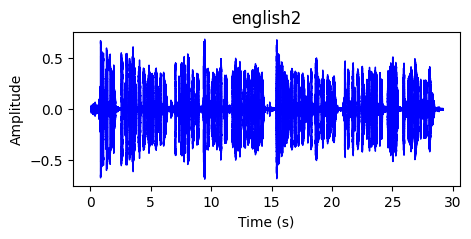

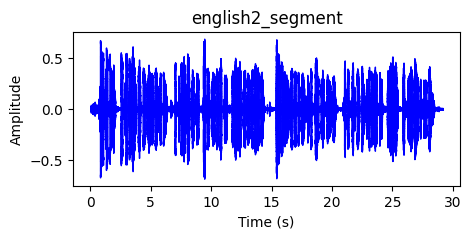

In [18]:
audible_segments = split_audio_by_silence(
    audio2,
    SAMPLING_RATING,
    threshold_percentage=THRESHOLD_PERCENTAGE,
    min_silence_duration=MIN_SILENCE_DURATION,
    frame_length_energy=FRAME_LENGTH_ENERGY,
    hop_length=HOP_LENGTH,
)
print("Number of audible segments:", len(audible_segments))
segment=audible_segments[0]
plot_audio(audio2, SAMPLING_RATING, title="english2", figsize=(5, 2))
plot_audio(segment, SAMPLING_RATING, title="english2_segment", figsize=(5, 2))

#import soundfile as sf
#sf.write("../data/processed/hindi2_segment.mp3", segment, SAMPLING_RATING)

segment audio

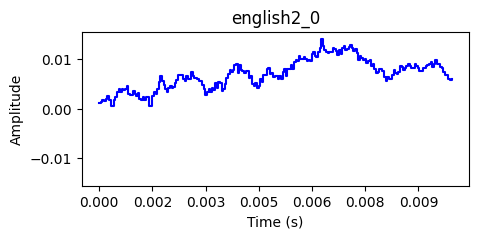

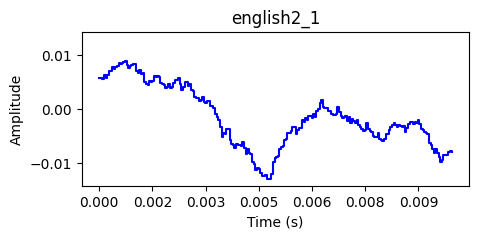

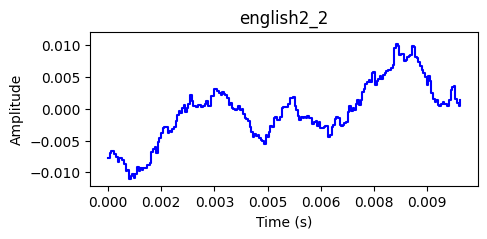

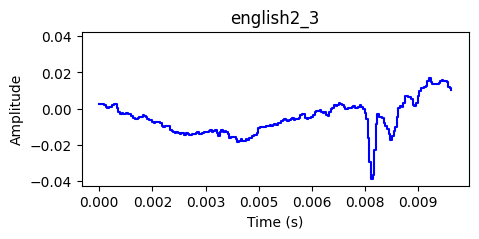

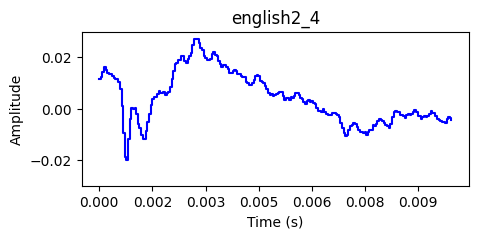

In [19]:
# Segment audio
segments = segment_audio(audio2, sr=SAMPLING_RATING, duration=0.01, overlap=0.001) # duration=10ms, overlap=1ms
for i, segment in enumerate(segments[:5]):
    plot_audio(segment, SAMPLING_RATING, title="english2_{}".format(i), figsize=(5, 2))

Load all audio files with the corresponding labels (accents) 

In [20]:
audio_data, labels = load_audio_files("../data/raw/recordings/", sr=SAMPLING_RATING)
unique_labels=set(labels)
print(f'there are {len(unique_labels)} unique labels: {unique_labels}')
print(f'there are {len(audio_data)} audio files')

there are 3 unique labels: {'korean', 'french', 'english'}
there are 165 audio files


Visualize the number of recordings in each accent

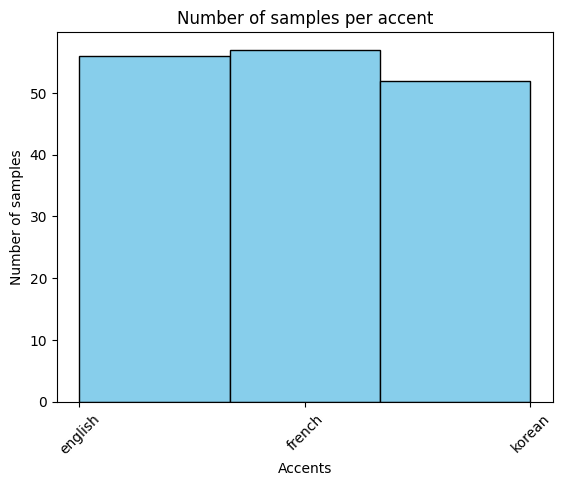

In [21]:
plt.hist(labels, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()


Trim silence part and store all segments as individual audios with the corresponding labels

In [25]:
#trim silence part and store all segments as individual audios with the corresponding labels
audio_data_trimmed = []
labels_trimmed = []
for i, audio in enumerate(audio_data):
    audible_segments = split_audio_by_silence(
        audio,
        SAMPLING_RATING,
        threshold_percentage=THRESHOLD_PERCENTAGE,
        min_silence_duration=MIN_SILENCE_DURATION,
    )
    audio_data_trimmed.extend(audible_segments)
    labels_trimmed.extend([labels[i]] * len(audible_segments))

KeyboardInterrupt: 

False


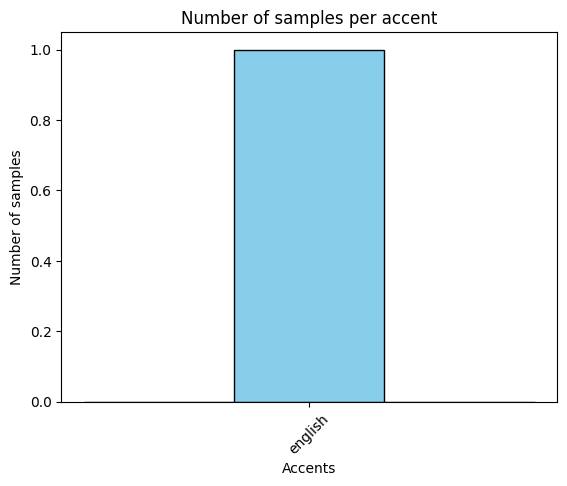

In [ ]:
print(len(audio_data_trimmed)==len(audio_data))
plt.hist(labels_trimmed, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()


segment audio data

In [26]:
# audio_data_segmented = []
# labels_segmented = []
# for i, audio in enumerate(audio_data_trimmed):
#     segments = segment_audio(
#         audio, SAMPLING_RATING, duration=SEGMENT_DURATION, overlap=SEGMENT_OVERLAP
#     )
#     audio_data_segmented.extend(segments)
#     labels_segmented.extend([labels_trimmed[i]] * len(segments))
#     # for j, segment in enumerate(segments):
#     #     np.save(f"../data/processed/segments/{labels_trimmed[i]}_{i}_{j}.npy", segment)

In [28]:
# print(f"there are {len(audio_data_segmented)} segments .")

### extract features

extract MFCCs

In [29]:
# extract MFCC features from trimmed audio data (not on segmented audio data because the function itself will split the audio data into segments)
mfccs = []
for audio in audio_data_trimmed:
    mfcc = compute_mfcc(
        audio, SAMPLING_RATING, n_mfcc=N_MFCC, duration=SEGMENT_DURATION, overlap=SEGMENT_OVERLAP
    )
    mfccs.append(mfcc)

In [30]:
print(f"len(mfccs): {len(mfccs)}")
print(f"num_segments for mfccs[0]: {mfccs[0].shape[1]}")
print(f"num_segments for mfccs[5]: {mfccs[5].shape[1]}")

len(mfccs): 102
num_segments for mfccs[0]: 2193
num_segments for mfccs[5]: 1918


In [31]:
# we want to split the mfccs into segments with the corresponding labels

# Initialize lists to store segments and their corresponding labels
segmented_mfccs = []
segmented_labels = []

# Iterate over each audio
for i, mfcc in enumerate(mfccs):
    # Get the shape of MFCCs and label for the current audio
    mfcc_shape = mfcc.shape
    label = labels_trimmed[i]

    # Extract the number of segments and the number of frames per segment
    num_segments = mfcc.shape[1]  # Second dimension of the MFCC shape

    # Iterate over each segment in the current audio
    for j in range(num_segments):
        # Extract the MFCCs for the current segment
        mfcc_segment = mfccs[i][:, j]

        # Append the segment and its corresponding label to the lists
        segmented_mfccs.append(mfcc_segment)
        segmented_labels.append(label)

# Convert the lists to NumPy arrays
# segmented_mfccs = np.array(segmented_mfccs)
# segmented_labels = np.array(segmented_labels)

print(f"len(segmented_mfccs): {len(segmented_mfccs)}")
print(f"len(segmented_labels): {len(segmented_labels)}")
print(f"segmented_mfccs[0]: {len(segmented_mfccs[0])}")
print(f"segmented_labels[0]: {segmented_labels[0]}")

len(segmented_mfccs): 249608
len(segmented_labels): 249608
segmented_mfccs[0]: 13
segmented_labels[0]: english
